<a href="https://colab.research.google.com/github/TFmohamedyahia/image_classification/blob/main/mnist_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [3]:
#2. Data preparation
# Load data

!mkdir -p ~/.kaggle
!cp kaggle.json -p ~/.kaggle

!kaggle competitions download -c digit-recognizer

 78% 12.0M/15.3M [00:00<00:00, 124MB/s]
100% 15.3M/15.3M [00:00<00:00, 141MB/s]


In [4]:
# extract zipfile of dataset
import zipfile

zip = zipfile.ZipFile('/content/digit-recognizer.zip','r')
zip.extractall('/content')
zip.close()

In [15]:
# read data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [6]:
# print(train[:3])
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [16]:
y_train = train["label"]

# Drop 'label' column
x_train = train.drop(labels = ["label"],axis = 1)

# free some space
del train

y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [19]:
# Check for null and missing values
x_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [21]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [22]:
# Normalize the data
x_train = x_train / 255.0
test = test / 255.0

In [24]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [29]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
# Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

y_train = to_categorical(y_train, num_classes = 10)

In [30]:
# Set the random seed
random_seed = 2

In [31]:
# Split the train and the validation set for the fitting
x_train, x_val, y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

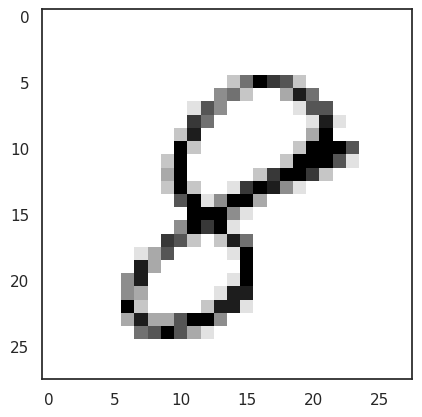

In [50]:
# Some examples
g = plt.imshow(x_train[0],cmap= 'binary')

In [58]:
# Set the CNN model
# CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential([
    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)),
    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'),
    Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation = "relu"),
    Dropout(0.5),
    Dense(10, activation = "softmax"),
])

In [59]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [60]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [61]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [66]:
epochs = 3 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [67]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [68]:
# Fit the model
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,Y_val),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/3


<ipython-input-68-c18192a90b9b>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


439/439 - 13s - loss: 0.0972 - accuracy: 0.9719 - val_loss: 0.0536 - val_accuracy: 0.9833 - lr: 0.0010 - 13s/epoch - 30ms/step
Epoch 2/3


439/439 - 14s - loss: 0.0811 - accuracy: 0.9759 - val_loss: 0.0300 - val_accuracy: 0.9910 - lr: 0.0010 - 14s/epoch - 33ms/step
Epoch 3/3


439/439 - 13s - loss: 0.0764 - accuracy: 0.9775 - val_loss: 0.0242 - val_accuracy: 0.9921 - lr: 0.0010 - 13s/epoch - 29ms/step


132/132 [==============================] - 0s 3ms/step


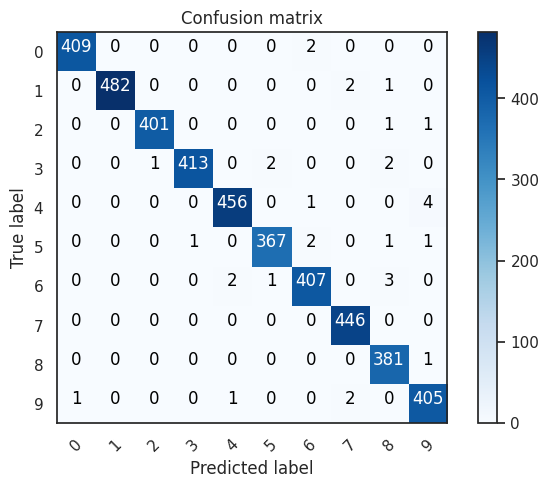

In [81]:
# Look at confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

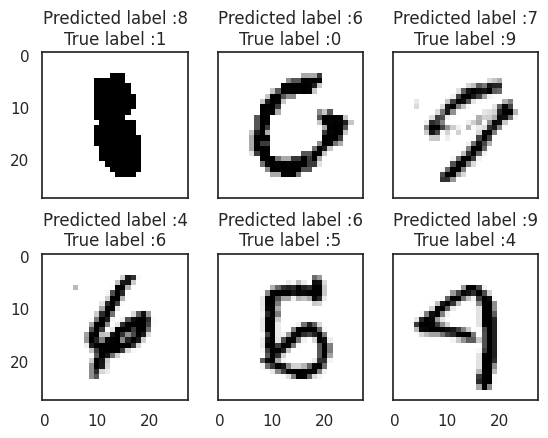

In [82]:
# Display some error results

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap= 'binary')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)